# Basic Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt


sns.set_style("whitegrid")

In [ ]:
clinical=pd.read_csv("/content/train_clinical_data.csv")
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2590 non-null   float64
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 163.6+ KB


In [ ]:
clinical.head(10)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


# Check for missing values

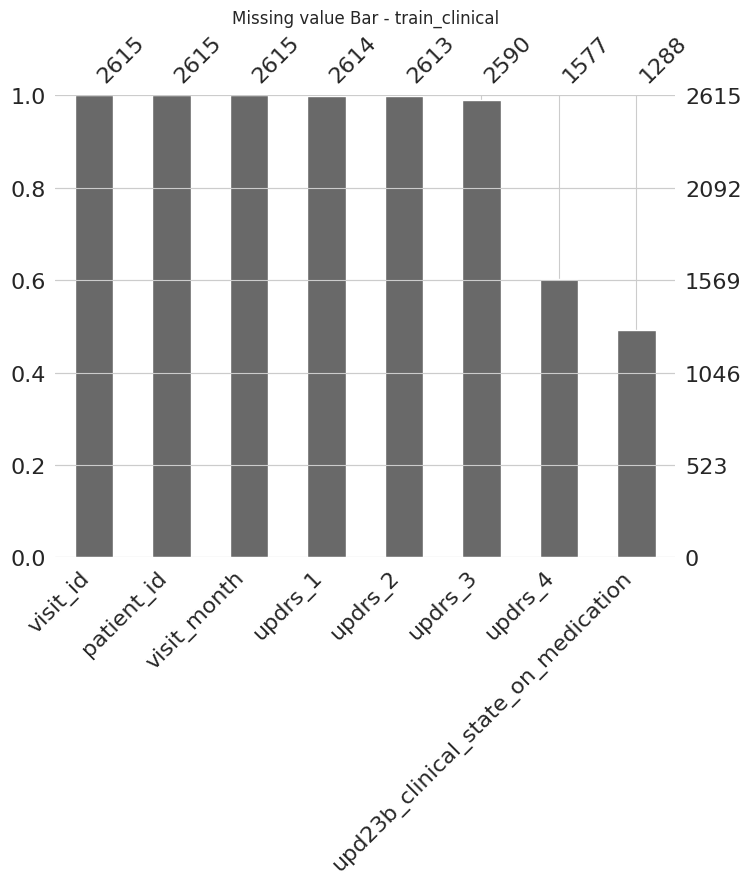

In [ ]:
msno.bar(clinical,figsize=(8,6))
plt.title("Missing value Bar - train_clinical")
plt.show()

# Check for duplicated values

In [ ]:
clinical.duplicated().sum()

np.int64(0)

# Conclusion: there are minor missing values for `updrs_1`, `updrs_2` and `updrs_3` scores, and major missing values for `updrs_4` scores and `upd23b_clinical_state_on_medication`, but there is no duplicated value.

# Time Series analysis

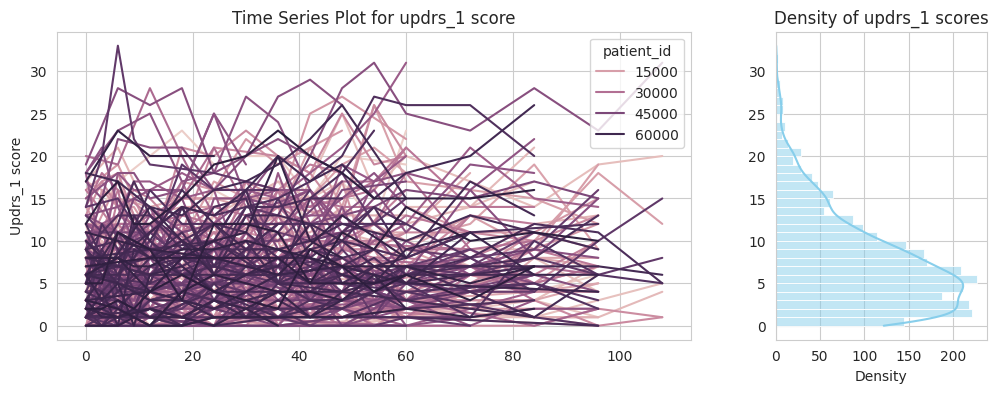

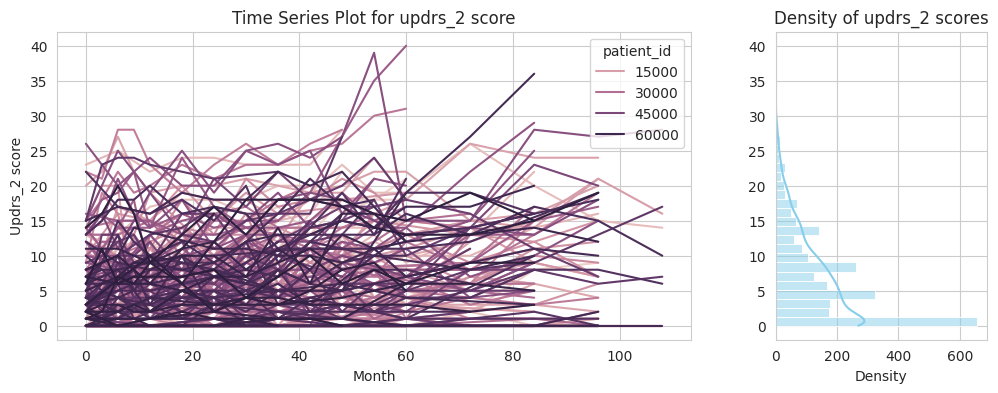

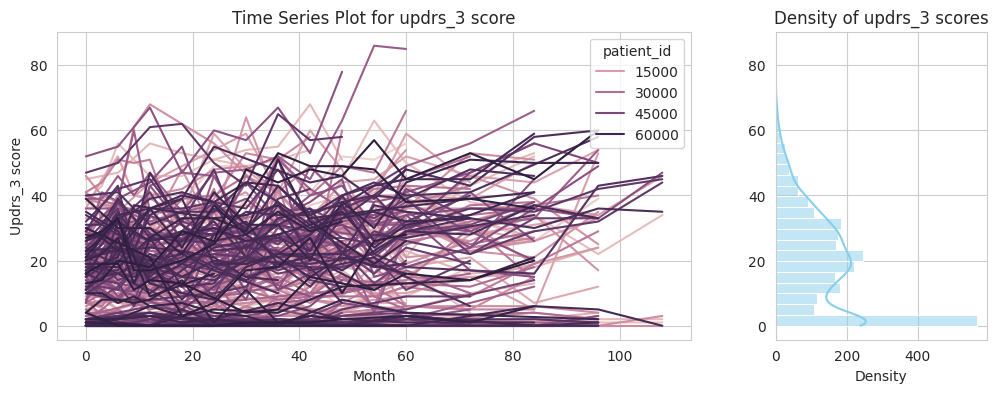

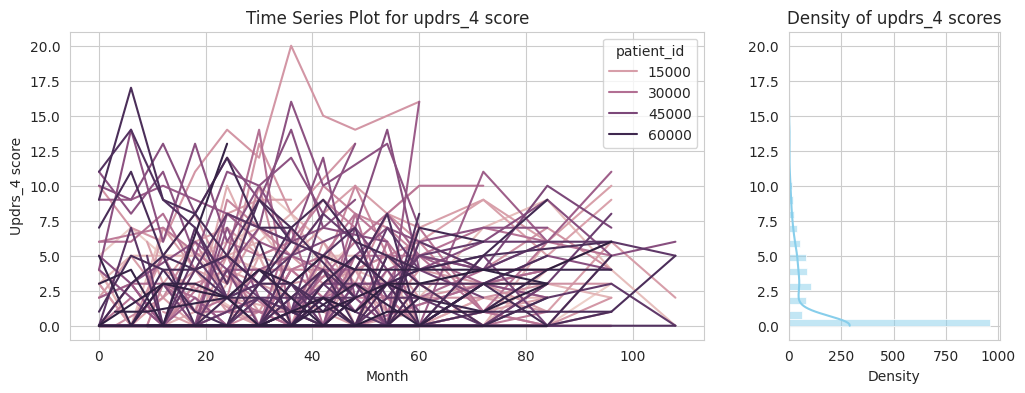

In [ ]:
for i in range(0,4):

  updrs_score=clinical[['patient_id','visit_month',f"updrs_{i+1}"]]
  updrs_score=updrs_score.dropna()

  fig, (ax_time, ax_density) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})

  # Time series plot
  sns.lineplot(x='visit_month', y=f"updrs_{i+1}", data=updrs_score, hue="patient_id", ax=ax_time)
  ax_time.set_title(f"Time Series Plot for updrs_{i+1} score")
  ax_time.set_xlabel("Month")
  ax_time.set_ylabel(f"Updrs_{i+1} score")


  # KDE plot (vertical to match right-side layout)
  sns.histplot(y=updrs_score[f"updrs_{i+1}"], ax=ax_density, fill=True, color='skyblue', kde=True)
  ax_density.set_title(f"Density of updrs_{i+1} scores")
  ax_density.set_xlabel("Density")
  ax_density.set_ylabel("")


We can also visualize the density of updrs scores in a 3D plot, where the z-axis is the density, x-axis is the `visit_month` and y-axis is the `updrs_score`.

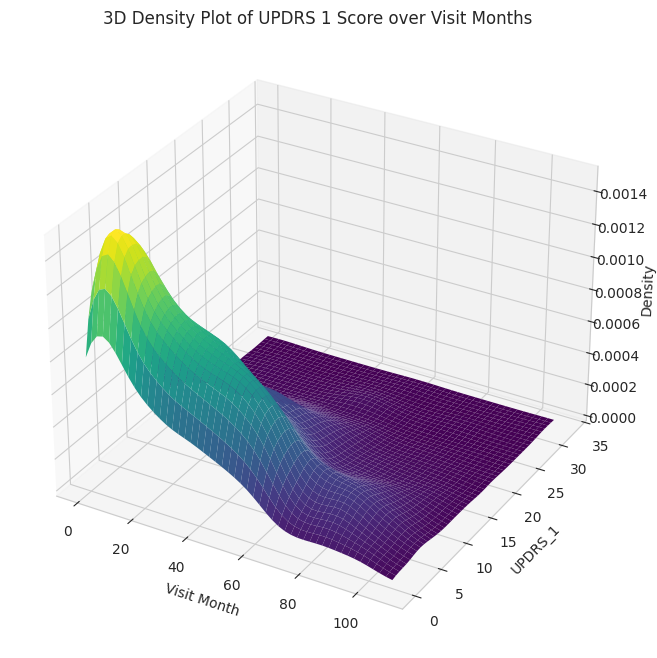

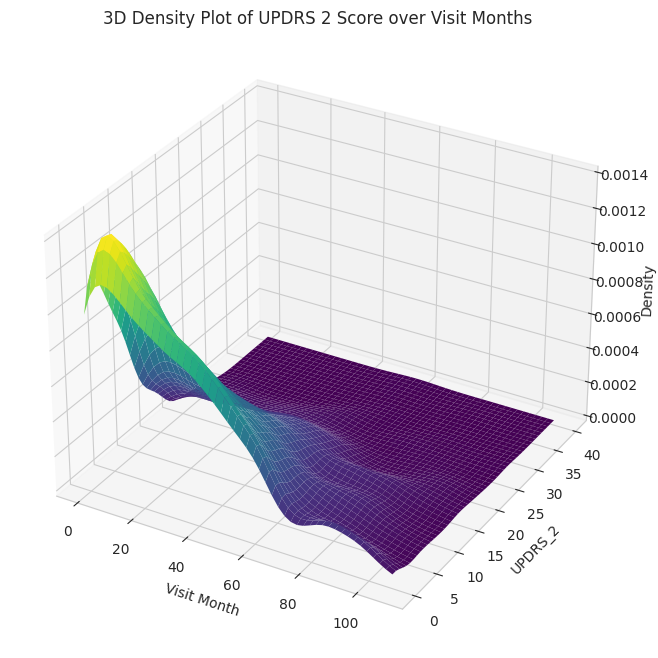

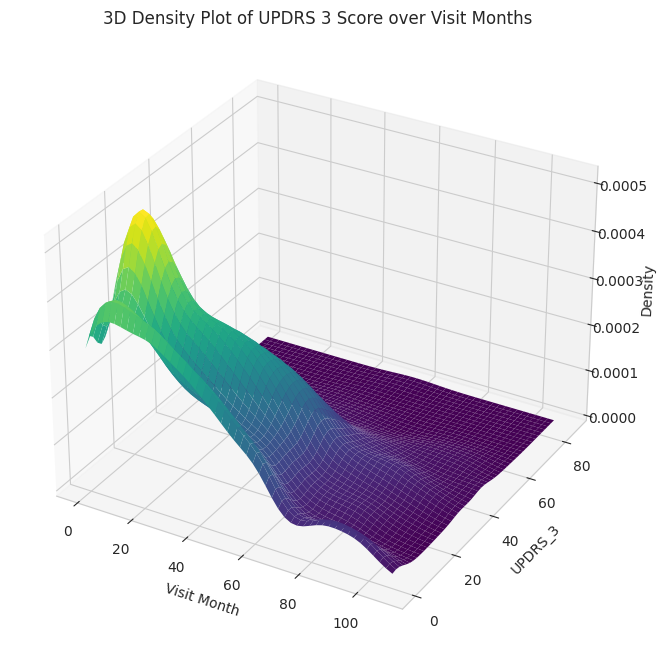

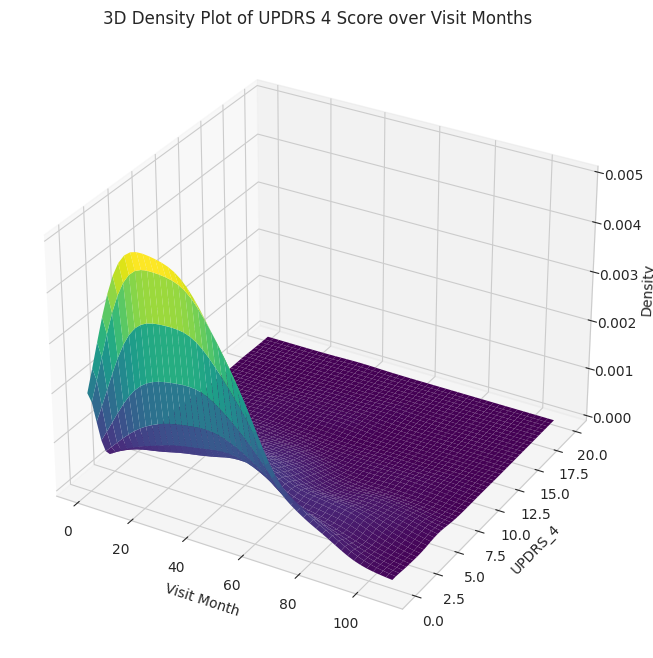

In [ ]:
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D

for i in range(0,4):

  updrs_score=clinical[['patient_id','visit_month',f"updrs_{i+1}"]]
  updrs_score=updrs_score.dropna()


  x = updrs_score['visit_month'].values
  y = updrs_score[f'updrs_{i+1}'].values

  # Stack into a 2D array for KDE
  xy = np.vstack([x, y])
  kde = gaussian_kde(xy)

  # Create a grid over the (x, y) space
  x_grid = np.linspace(x.min(), x.max(), 50)
  y_grid = np.linspace(y.min(), y.max(), 50)
  X, Y = np.meshgrid(x_grid, y_grid)
  Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

  # Plot
  fig = plt.figure(figsize=(12, 8))
  ax = fig.add_subplot(111, projection='3d')

  ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

  ax.set_xlabel('Visit Month')
  ax.set_ylabel(f'UPDRS_{i+1}')
  ax.set_zlabel('Density')

  plt.title(f"3D Density Plot of UPDRS {i+1} Score over Visit Months")
plt.show()

In the data description, it is said that

> upd23b_clinical_state_on_medication - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.

The following code is to see whether there is a patient taking two tests in a single month.


In [ ]:
visit_id_series=clinical.visit_id.value_counts()
visit_id_table=visit_id_series.reset_index()
more_than_one_time_visit_in_one_month=visit_id_table[visit_id_table['count']>1]
if len(more_than_one_time_visit_in_one_month)==0:
  print("No patient took two or more tests in a single month!")
else:
  for i in range(len(more_than_one_time_visit_in_one_month)):
    the_visit_id=more_than_one_time_visit_in_one_month['visit_id']
    the_visit_id.split("_")
    the_patient_id, the_visit_month=the_visit_id[0], the_visit_id[1]
    print(f"patient {the_patient_id} took two test in month {the_visit_month}")



No patient took two or more tests in a single month!


# Since the core objective is to predict the updrs score with protein and peptide abundance, we can look at the joined table -- See next notebook.